In [1]:
import SOE_NET_1D as v1
import SOE_Net_model_full as v3
import tensorflow as tf
import numpy as np
import configure as cfg
import init_SOE_NET as init_net

In [2]:
tf.compat.v1.enable_eager_execution()

In [ ]:
orientations = np.array(init_net.initOrientations (cfg.ORIENTATIONS,cfg.SPEEDS,cfg.NUM_DIRECTIONS), dtype=np.float32)
basis = init_net.initSeparableFilters('basis', cfg.FILTER_TAPS, filter_type="G3").astype(np.float32)
biases = init_net.initBiases('bias', 0)

In [4]:
basis.shape

(5, 13)

# 1D version

In [81]:
vol1 = np.random.rand(1, 42, 10)
vol1 = tf.constant(vol1, dtype=tf.float32)

In [16]:
basis[0,0]

-0.004087332711350828

In [6]:
conv2 = v1.SC1D('conv1', vol1, basis)

2022-04-29 11:50:20.728835: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-04-29 11:50:21.270036: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


In [11]:
import configure as cfg
import init_SOE_NET as init_net
import numpy as np
import tensorflow as tf
from SOE_NET_1D import conv1d

In [12]:
tf.compat.v1.enable_eager_execution()

In [3]:
gau_filter = init_net.initSeparableFilters('basis', cfg.FILTER_TAPS, filter_type="G3")

2022-06-13 12:00:43.666422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-13 12:00:43.694760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Quadro P6000 major: 6 minor: 1 memoryClockRate(GHz): 1.645
pciBusID: 0000:65:00.0
2022-06-13 12:00:43.695104: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-13 12:00:43.697606: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-13 12:00:43.699703: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-13 12:00:43.700228: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-06-13 12:00:43.702142: I tensorflow/stream_executor/platform/defa

In [4]:
gau_filter.dtype

tf.float32

In [40]:
print(2**18)

262144


In [7]:
import audio2numpy as a2n
x,sr=a2n.audio_from_file("bee_102.mp3")

In [8]:
from util import highestPowerof2
n = highestPowerof2(x.shape[0])
x = x[x.shape[0]//2 - n // 2 : x.shape[0] // 2 + n //2, :]

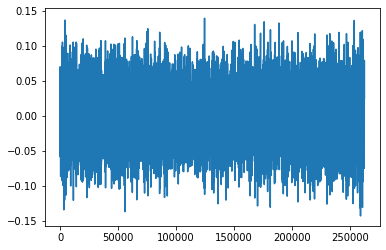

In [9]:
import matplotlib.pyplot as plt       
plt.plot(x[:,1])
plt.show()

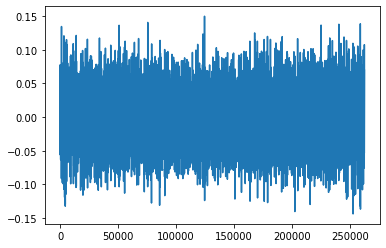

In [78]:
import matplotlib.pyplot as plt       
plt.plot(x[:,0])
plt.show()

In [79]:
vol = tf.constant(x[None,:,:], dtype=tf.float32)
vol.shape

TensorShape([Dimension(1), Dimension(262144), Dimension(2)])

In [55]:
vol = np.random.rand(1, 1024, 1)
vol = tf.constant(vol, dtype=tf.float32)

In [80]:
from SOE_NET_1D import SOE_Net
output = SOE_Net(vol, gau_filter)

In [81]:
output.shape

TensorShape([Dimension(1), Dimension(24)])

In [83]:
output

<tf.Tensor: id=34581309, shape=(1, 24), dtype=float32, numpy=
array([[5.5490687e-02, 5.6729257e-02, 9.8853445e-01, 1.0223104e+00,
        1.9524168e+01, 2.0023069e+01, 3.8774640e+02, 3.7536670e+02,
        5.0228735e+03, 4.6052988e+03, 3.8228547e+04, 3.8802906e+04,
        5.5502128e-02, 5.6776330e-02, 9.8632181e-01, 1.0180794e+00,
        1.9425150e+01, 1.9869133e+01, 3.7861490e+02, 3.6697806e+02,
        4.9291152e+03, 4.5775806e+03, 3.8602344e+04, 3.8763688e+04]],
      dtype=float32)>

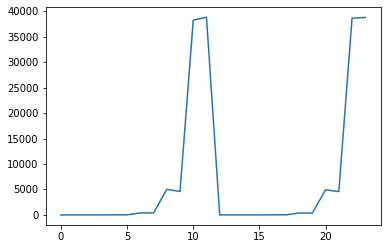

In [82]:
plt.plot(output.numpy()[0,:])
plt.show()

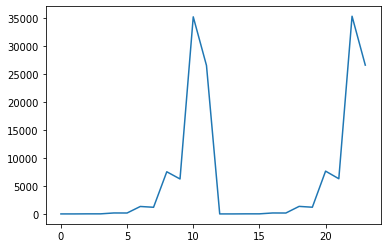

In [74]:
plt.plot(output.numpy()[0,:])
plt.show()

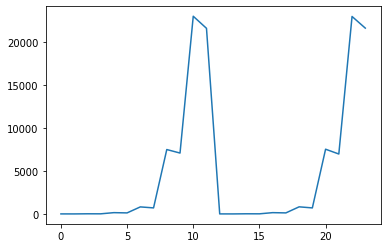

In [66]:
plt.plot(output.numpy()[0,:])
plt.show()

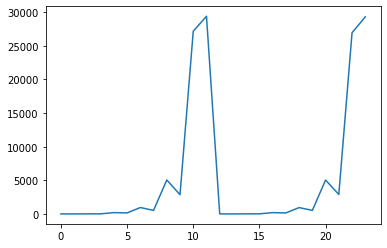

In [60]:
plt.plot(output.numpy()[0,:])
plt.show()

In [1]:
import configure as cfg
import init_SOE_NET as init_net
import numpy as np
import tensorflow as tf
from SOE_NET_1D import conv1d

In [2]:
tf.compat.v1.enable_eager_execution()

In [9]:
n = 2**(17)
delta = [0] * n
delta[n//2] = 1
vol = tf.constant(delta, dtype=tf.float32)[None, :, None]
gau_filter = init_net.initSeparableFilters('basis', cfg.FILTER_TAPS, filter_type="G3")

In [4]:
def SC1D(in_data, basis, num_scale):

    original_temporal_res = in_data.shape[1]
    # Binomial filter to be used for downsampling
    binomial_filter = tf.constant(np.array([1, 4, 6, 4, 1])/16, dtype=tf.float32)

    all_scales = []

    # downsampling untill the level of desire
    all_scales.append(in_data)
    for scale in range(1, num_scale + 1):
        in_data = conv1d('downsampling_smoothing_scale{}'.format(scale), in_data, binomial_filter)
        mask = tf.not_equal(tf.range(tf.shape(in_data)[1]) % cfg.DOWN_SAMPLE_FACTOR, 0)
        in_data = tf.boolean_mask(in_data, mask, axis=1)
        all_scales.append(in_data)

    # applying filter of interest and upscaling
    for i in range(num_scale + 1):
        vol = conv1d('G_a_scale{}'.format(i), all_scales[i], basis[0,:])
        while vol.shape.as_list()[1] != original_temporal_res:
            vol = tf.keras.layers.UpSampling1D(size=cfg.DOWN_SAMPLE_FACTOR)(vol)
            mask = tf.constant([0,1] * (vol.shape.as_list()[1] // 2), dtype=tf.float32)[None, :, None]
            mask = tf.repeat(mask, repeats=[vol.shape[-1]], axis=-1)
            vol = vol * mask
            vol = 1 * conv1d('downsampling_smoothing_scale{}'.format(i), vol, binomial_filter)

#         vol = vol / cfg.MULTI_SCALING_NORM_FACTORS[i] 
        all_scales[i] = vol
    

    vols = tf.concat(axis=-1, values=all_scales, name='concatScales')            
    return vols

1048576

In [10]:
output = SC1D(vol, gau_filter, 15)

In [6]:
output[0,:,15]

<tf.Tensor: id=14693738, shape=(1048576,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [67]:
out_np = output.numpy()

In [68]:
out_np = out_np.squeeze()

In [69]:
out_np = np.sum(out_np*out_np, axis = 0)

In [70]:
out_np

array([1.27294004e+00, 7.02542290e-02, 7.57212192e-03, 9.15596494e-04,
       1.13530281e-04, 1.41629107e-05, 1.76947970e-06, 2.21157464e-07,
       2.76437877e-08, 3.45544504e-09, 4.31928160e-10, 5.39905898e-11,
       6.74876084e-12, 8.43561278e-13, 1.05441284e-13, 1.31790534e-14],
      dtype=float32)

In [71]:
np.save("scales_factor1.npy", out_np)

In [48]:
scales = np.load("scales.npy")

In [61]:
scales

array([[[1.2729400e+00, 2.8101692e-01, 1.2115395e-01, 5.8598176e-02,
         2.9063752e-02, 1.4502821e-02, 7.2477888e-03, 3.6234439e-03,
         1.8116633e-03, 9.0582418e-04, 4.5290950e-04]]], dtype=float32)

In [1]:
def SOE_Net(video, basis):
    
    with tf.name_scope('Layer1'):
        conv1 = SC1D('conv1', video, basis, cfg.NUM_SCALES)
        if cfg.REC_STYLE == 'two_path':
            rec1 = TPR('Rec1', conv1)
        else:
            rec1 = FWR('Rec1', conv1)
            
        norm1 = DivNorm1d('norm1', rec1, cfg.EPSILON)
        feat = GSP('GSP',norm1)
        


    return feat

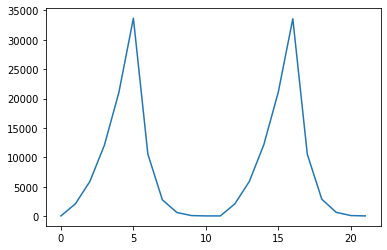

In [5]:
import configure as cfg
import init_SOE_NET as init_net
import numpy as np
import tensorflow as tf
from SOE_NET_1D import conv1d
from util import highestPowerof2
import audio2numpy as a2n
import matplotlib.pyplot as plt       
from SOE_NET_1D import SC1D, TPR, FWR, DivNorm1d, GSP


tf.compat.v1.enable_eager_execution()

gau_filter = init_net.initSeparableFilters('basis', cfg.FILTER_TAPS, filter_type="G3")

x,sr=a2n.audio_from_file("wavy_water_223.mp3")
x = x[:,0][:,None]
n = highestPowerof2(x.shape[0])
x = x[x.shape[0] // 2 - n // 2 : x.shape[0] // 2 + n // 2, :]
vol = tf.constant(x[None,:,:], dtype=tf.float32)
output = SOE_Net(vol, gau_filter)
plt.plot(output.numpy()[0,:])
plt.show()


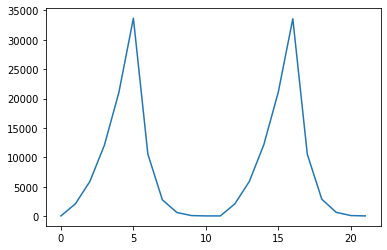

In [5]:
output = SOE_Net(vol, gau_filter)
plt.plot(output.numpy()[0,:])
plt.show()


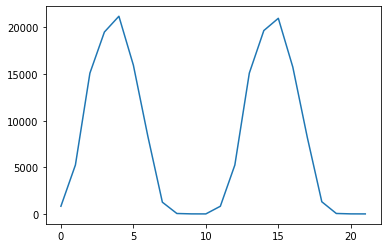

In [18]:
import configure as cfg
import init_SOE_NET as init_net
import numpy as np
import tensorflow as tf
from SOE_NET_1D import conv1d
from util import highestPowerof2
import audio2numpy as a2n
import matplotlib.pyplot as plt       
from SOE_NET_1D import SC1D, TPR, FWR, DivNorm1d, GSP


tf.compat.v1.enable_eager_execution()

gau_filter = init_net.initSeparableFilters('basis', cfg.FILTER_TAPS, filter_type="G3")

x,sr=a2n.audio_from_file("./videos/wavy_water_109.mp3")
x = ((x[:,0] + x[:,1])/2)[:,None]
n = highestPowerof2(x.shape[0])
x = x[x.shape[0] // 2 - n // 2 : x.shape[0] // 2 + n // 2, :]
vol = tf.constant(x[None,:,:], dtype=tf.float32)
output = SOE_Net(vol, gau_filter)
plt.plot(output.numpy()[0,:])
plt.show()


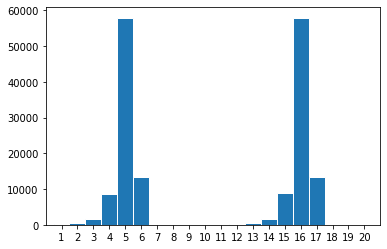

In [4]:
x_range = output.numpy().shape[1]
from util import bar_plot
bar_plot(range(x_range), output.numpy()[0,:])

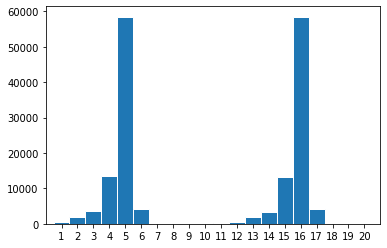

In [7]:
x_range = output.numpy().shape[1]
from util import bar_plot
bar_plot(range(x_range), output.numpy()[0,:])

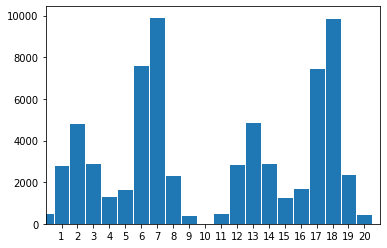

In [10]:
x_range = output.numpy().shape[1]
from util import bar_plot
bar_plot(range(x_range), output.numpy()[0,:])

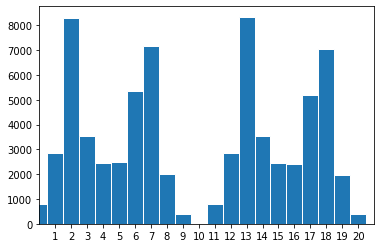

In [13]:
x_range = output.numpy().shape[1]
from util import bar_plot
bar_plot(range(x_range), output.numpy()[0,:])

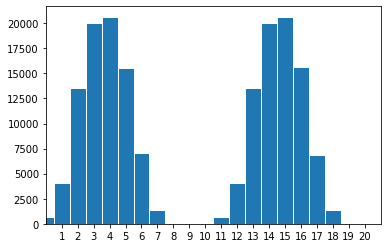

In [16]:
x_range = output.numpy().shape[1]
from util import bar_plot
bar_plot(range(x_range), output.numpy()[0,:])

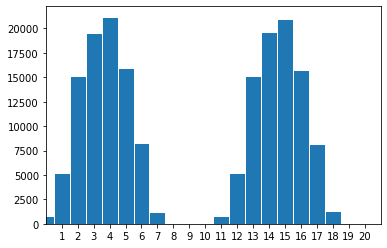

In [19]:
x_range = output.numpy().shape[1]
from util import bar_plot
bar_plot(range(x_range), output.numpy()[0,:])

In [5]:
output1 = output

In [8]:
output2 = output

In [11]:
output3 = output

In [14]:
output4 = output

In [17]:
output5 = output

In [20]:
output6 = output

In [21]:
output1 = output1.numpy().squeeze()
output2 = output2.numpy().squeeze()
output3 = output3.numpy().squeeze()
output4 = output4.numpy().squeeze()
output5 = output5.numpy().squeeze()
output6 = output6.numpy().squeeze()

In [49]:
import numpy as np
from numpy.linalg import norm

def similarity(A,B):
    # compute cosine similarity
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    return cosine

In [50]:
similarity(output2, output1)

0.9848804

In [47]:
outputs = [output1,output2,output3,output4,output5,output6]

In [53]:
inner_sims = []
between_sims = []
for i in range(len(outputs)):
    for j in range(i, len(outputs)):
        if i == j:
            continue
        if j - i == 1 and i % 2 == 0:
            inner_sims.append(similarity(outputs[i], outputs[j]))
        else:
            between_sims.append(similarity(outputs[i], outputs[j]))            

In [54]:
inner_sims

[0.9848804, 0.9305928, 0.9982757]

In [56]:
len(between_sims)

12

In [57]:
inner_sims + between_sims

[0.9848804,
 0.9305928,
 0.9982757,
 0.25585574,
 0.29992113,
 0.5581558,
 0.5570819,
 0.1976879,
 0.2777824,
 0.60010386,
 0.5943513,
 0.4907566,
 0.5118491,
 0.66986716,
 0.693938]

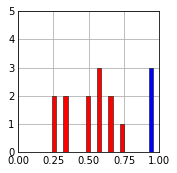

In [68]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')


# plot:
fig, ax = plt.subplots()

ax.hist([inner_sims, between_sims], bins=10, linewidth=0.5, edgecolor="black", color=['blue', 'red'])

ax.set(xlim=(0, 1),
       ylim=(0, 5))

plt.show()

In [44]:
np.linspace(0, 56, 9)

array([ 0.,  7., 14., 21., 28., 35., 42., 49., 56.])

# 100 soe net

In [1]:
def SOE_Net(video, basis):
    
    with tf.name_scope('Layer1'):
        conv1 = SC1D('conv1', video, basis, cfg.NUM_SCALES)
        if cfg.REC_STYLE == 'two_path':
            rec1 = TPR('Rec1', conv1)
        else:
            rec1 = FWR('Rec1', conv1)
            
        norm1 = DivNorm1d('norm1', rec1, cfg.EPSILON)
        feat = GSP('GSP',norm1)
        


    return feat

In [2]:
import configure as cfg
import init_SOE_NET as init_net
import numpy as np
import tensorflow as tf
from SOE_NET_1D import conv1d
from util import highestPowerof2
import audio2numpy as a2n
import matplotlib.pyplot as plt       
from SOE_NET_1D import SC1D, TPR, FWR, DivNorm1d, GSP
import os
from util import bar_plot


tf.compat.v1.enable_eager_execution()
gau_filter = init_net.initSeparableFilters('basis', cfg.FILTER_TAPS, filter_type="G3")

PATH_AUDIO = "/home/eftekhar/Documents/Databases/AVDT_backup/Audios"

2022-06-21 11:37:02.689802: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-21 11:37:02.711038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Quadro P6000 major: 6 minor: 1 memoryClockRate(GHz): 1.645
pciBusID: 0000:65:00.0
2022-06-21 11:37:02.711210: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-06-21 11:37:02.712355: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-06-21 11:37:02.713333: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-06-21 11:37:02.713574: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-06-21 11:37:02.714853: I tensorflow/stream_executor/platform/defa

In [5]:
classes = []
outputs = []
for d in os.listdir(PATH_AUDIO):
    classes.append(d)
    audios = os.listdir(os.path.join(PATH_AUDIO, d))
#     m = min(100, len(audios))
    for aud in os.listdir(os.path.join(PATH_AUDIO, d))[:1]:
        print(d)
        audio_path = os.path.join(PATH_AUDIO, d, aud)
        x,sr=a2n.audio_from_file(audio_path)
        x = ((x[:,0] + x[:,1])/2)[:,None]
        n = highestPowerof2(x.shape[0])
        x = x[x.shape[0] // 2 - n // 2 : x.shape[0] // 2 + n // 2, :]
        vol = tf.constant(x[None,:,:], dtype=tf.float32)
        output = SOE_Net(vol, gau_filter)
        outputs.append(output.numpy())
#         x_range = output.numpy().shape[1]
#         bar_plot(range(x_range), output.numpy()[0,:])
    

flag
piano
waterfall
rushing river
vegetation
airshow
fire
rainfall
running_train
car_traffic
firework
keyboard_typing
bee
drumline
wavy_water
geyser_fountain
school_of_fish
applause
string_orchestra


In [8]:
outputs

[array([[8.7454765e+01, 2.4609114e+03, 1.5494168e+04, 6.9025957e+03,
         7.3480186e+03, 4.5056312e+04, 1.1667762e+04, 7.1885156e+02,
         1.6580477e+00, 1.3234052e-01, 5.6501795e-02, 8.6287491e+01,
         2.4469626e+03, 1.5470098e+04, 6.9062773e+03, 7.3649595e+03,
         4.5096664e+04, 1.1827905e+04, 7.2836829e+02, 2.7728407e+00,
         6.2427771e-01, 2.0920685e-01]], dtype=float32),
 array([[1.7285893e+00, 1.7107788e+02, 2.1240042e+03, 1.3954226e+04,
         3.6071742e+04, 2.6174822e+04, 1.2805229e+04, 9.9791736e+02,
         2.9463830e+00, 4.9845308e-01, 1.9356367e-01, 1.7020694e+00,
         1.7103065e+02, 2.0626836e+03, 1.3750568e+04, 3.4869016e+04,
         2.6128688e+04, 1.3066096e+04, 1.0202292e+03, 2.8863783e+00,
         4.1321450e-01, 1.8426532e-01]], dtype=float32),
 array([[1.0479424e+03, 3.3277314e+03, 5.5204907e+03, 6.0862744e+03,
         8.7194502e+03, 1.1406028e+04, 2.1814141e+04, 2.8308715e+04,
         1.7877611e+04, 4.5085809e+02, 1.6385559e+01, 1.05

In [14]:
np.save("results.npy", np.concatenate(outputs, axis=0))

In [15]:
a = np.load("results.npy")

In [17]:
import pickle

with open("classes", "wb") as f:   #Pickling
    pickle.dump(classes, f)


In [18]:
with open("classes", "rb") as f:   # Unpickling
    cls = pickle.load(f)

In [19]:
classes

['flag',
 'piano',
 'waterfall',
 'rushing river',
 'vegetation',
 'airshow',
 'fire',
 'rainfall',
 'running_train',
 'car_traffic',
 'firework',
 'keyboard_typing',
 'bee',
 'drumline',
 'wavy_water',
 'geyser_fountain',
 'school_of_fish',
 'applause',
 'string_orchestra']

In [20]:
cls

['flag',
 'piano',
 'waterfall',
 'rushing river',
 'vegetation',
 'airshow',
 'fire',
 'rainfall',
 'running_train',
 'car_traffic',
 'firework',
 'keyboard_typing',
 'bee',
 'drumline',
 'wavy_water',
 'geyser_fountain',
 'school_of_fish',
 'applause',
 'string_orchestra']

In [ ]:
x,sr=a2n.audio_from_file("./videos/wavy_water_109.mp3")
x = ((x[:,0] + x[:,1])/2)[:,None]
n = highestPowerof2(x.shape[0])
x = x[x.shape[0] // 2 - n // 2 : x.shape[0] // 2 + n // 2, :]
vol = tf.constant(x[None,:,:], dtype=tf.float32)
output = SOE_Net(vol, gau_filter)
plt.plot(output.numpy()[0,:])
plt.show()


# Cosine similarity

In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
outputs = np.load("results.npy")

In [3]:
sim_pairs = cosine_similarity(outputs)

In [4]:
inner_similarity = []
between_similarity = []
for i in range(sim_pairs.shape[0]):
    for j in range(i, sim_pairs.shape[0]):
        if i == j:
            continue
        if i // 98 == j // 98:
            inner_similarity.append(sim_pairs[i,j])
        else:
            between_similarity.append(sim_pairs[i,j])

In [5]:
len(inner_similarity)

90307

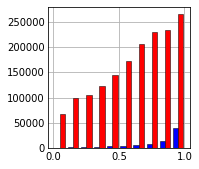

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter


plt.style.use('_mpl-gallery')


# plot:
# fig, ax = plt.subplots()

plt.hist([inner_similarity, between_similarity], bins=10, linewidth=0.5, edgecolor="black", color=['blue', 'red'],)
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.set(xlim=(0, 1))

plt.show()

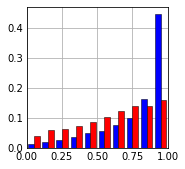

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter


plt.style.use('_mpl-gallery')


# plot:
fig, ax = plt.subplots()

ax.hist([inner_similarity, between_similarity], bins=10, linewidth=0.5, edgecolor="black", color=['blue', 'red'],weights=[np.ones_like(inner_similarity) / len(inner_similarity),np.ones_like(between_similarity) / len(between_similarity)])
ax.set(xlim=(0, 1))

plt.show()

In [34]:
len(list(filter(lambda x: 0.80 <x < 0.90, between_similarity)))/len(between_similarity)

0.14184635544156796

# Finding similar classes

In [11]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pandas as pd

In [2]:
with open("classes", "rb") as f:   # Unpickling
    classes = pickle.load(f)

In [3]:
outputs = np.load("results.npy")

In [4]:
sim_pairs = cosine_similarity(outputs)

In [5]:
NUM_CLASS = 19
SAMPLE_PER_CLASS = 98
class_vs_class = []
for i in range(NUM_CLASS):
    for j in range(i, NUM_CLASS):
        class_names = "{}_vs_{}".format(classes[i], classes[j])
        sub_sim = sim_pairs[i*SAMPLE_PER_CLASS: i*SAMPLE_PER_CLASS + SAMPLE_PER_CLASS, j*SAMPLE_PER_CLASS: j*SAMPLE_PER_CLASS + SAMPLE_PER_CLASS]
        c = SAMPLE_PER_CLASS if i==j else 0
        greater90 = (sub_sim[sub_sim > 0.9].shape[0] - c) / (SAMPLE_PER_CLASS**2)
        class_vs_class.append((class_names, greater90))

In [6]:
class_vs_class.sort(key= lambda x: x[1], reverse=True)

In [7]:
class_vs_class

[('flag_vs_flag', 0.9554352353186173),
 ('bee_vs_bee', 0.8835901707621824),
 ('flag_vs_bee', 0.881820074968763),
 ('airshow_vs_airshow', 0.6870054144106622),
 ('vegetation_vs_airshow', 0.6479591836734694),
 ('flag_vs_geyser_fountain', 0.6037067888379841),
 ('vegetation_vs_vegetation', 0.5970428987921699),
 ('geyser_fountain_vs_geyser_fountain', 0.5903790087463557),
 ('airshow_vs_rainfall', 0.588088296543107),
 ('bee_vs_geyser_fountain', 0.5795501874219076),
 ('applause_vs_applause', 0.5566430653894211),
 ('rainfall_vs_rainfall', 0.5264473136193253),
 ('vegetation_vs_rainfall', 0.5186380674718867),
 ('bee_vs_string_orchestra', 0.514369012911287),
 ('flag_vs_string_orchestra', 0.48021657642648896),
 ('flag_vs_school_of_fish', 0.476780508121616),
 ('rushing river_vs_rushing river', 0.4700124947938359),
 ('string_orchestra_vs_string_orchestra', 0.45564348188254894),
 ('airshow_vs_car_traffic', 0.4468971261974177),
 ('bee_vs_school_of_fish', 0.4299250312369846),
 ('bee_vs_wavy_water', 0.428

In [13]:
df = pd.DataFrame(class_vs_class)

In [14]:
df.to_csv('similarities.csv')

# Classification

In [5]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pandas as pd
from scipy import stats

In [18]:
with open("20classes", "rb") as f:   # Unpickling
    classes = pickle.load(f)

In [19]:
outputs = np.load("results_2layer_numscale20_downfac_root_2_no_norm1_librosa_44100_two_path_kaiser_fast_20_classes_100videos.npy")

In [20]:
outputs.shape

(2000, 1764)

In [21]:
sim_pairs = cosine_similarity(outputs)

In [22]:
sorted_sim = np.argsort(sim_pairs, axis=1)

In [23]:
NN = sorted_sim[:,-2].tolist()
c = 0
for i, s in enumerate(NN):
    if s // 100 == i // 100:
        c = c + 1
c / len(NN)        

0.5345

In [12]:
top5 = sorted_sim[:,-6:-1]
c = 0
for i in range(top5.shape[0]):
    if (i // 100) in (top5[i] // 100).tolist():
        c += 1
c / top5.shape[0]

0.8075

In [19]:
KNN = sorted_sim[:,-5:-1]

In [20]:
KNN = KNN // 98
mode = stats.mode(KNN.T)
mode[0]

array([[15,  0,  6, ...,  2,  4, 18]])

In [21]:
c = 0
for i, s in enumerate(mode[0].squeeze().tolist()):
    if s == i // 98:
        c = c + 1
c / len(NN)        

0.5585392051557465

In [99]:
mode[0].squeeze().tolist()

[15,
 11,
 12,
 0,
 0,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 18,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 16,
 14,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,
 14,
 0,
 0,
 0,
 0,
 0,
 15,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 16,
 0,
 16,
 0,
 0,
 16,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 16,
 0,
 0,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 14,
 0,
 18,
 0,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 5,
 12,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 9,
 1,
 8,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 4,
 1,
 8,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 18,
 1,
 8,
 6,
 16,
 1,
 1,
 1,
 8,
 1,
 1,
 13,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 4,
 9,
 1,
 5,
 6,
 1,
 1,
 1,
 1,
 1,
 10,
 3,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 8,
 1,
 1,
 1,
 1,
 1,
 1,
 8,
 5,
 1,
 1,
 18,
 4,
 2,
 16,
 2,
 2,
 7,
 15,
 14,
 2,
 14,
 14,
 2,
 14,
 2,
 3,
 14,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 7,
 2,
 2,
 2,
 2,
 14,
 3,
 2,
 2,
 11,
 2,
 2,
 15,
 2,
 2,
 2,
 10,
 2,
 2,
 2,
 2,
 14,

In [30]:
outputs.shape

(1862, 42)

In [48]:
np.load('scales_librosa.npy')

array([1.2729399 , 0.90011156, 0.6365104 , 0.45020866, 0.3184085 ,
       0.22518179, 0.15936026, 0.11266714, 0.07983626, 0.05648889,
       0.04007097, 0.02840197, 0.02010614, 0.01411424, 0.01021266,
       0.00728996, 0.00527258, 0.00355556, 0.00281423, 0.00177788,
       0.00150499], dtype=float32)

<Figure size 3600x3600 with 0 Axes>

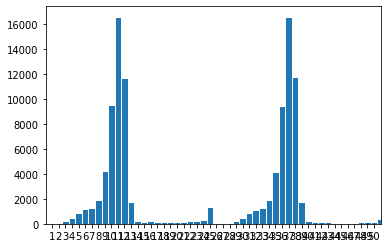

In [31]:
x_range = outputs.shape[1]
from util import bar_plot
bar_plot(range(x_range), outputs[555])

# classification with combined features (first and second layers)

In [19]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pandas as pd
from scipy import stats

In [20]:
with open("20classes", "rb") as f:   # Unpickling
    classes = pickle.load(f)

In [26]:
outputs2 = np.load("results_3layer_numscale20_downfac_root_2_no_norm1_librosa_44100_one_path_kaiser_fast_20_classes_100videos.npy")

In [27]:
outputs1 = np.load("results_2layer_numscale20_downfac_root_2_no_norm1_librosa_44100_one_path_kaiser_fast_20_classes_100videos.npy")

In [28]:
outputs1 = outputs1 / np.linalg.norm(outputs1, axis=1)[:,None]
outputs2 = outputs2 / np.linalg.norm(outputs2, axis=1)[:,None]

In [9]:
alpha = 1
outputs = alpha * outputs1 + (1 - alpha) * outputs2

In [29]:
outputs = np.concatenate((outputs1, outputs2), axis=-1)

In [30]:
sim_pairs = cosine_similarity(outputs)
sorted_sim = np.argsort(sim_pairs, axis=1)

NN = sorted_sim[:,-2].tolist()
c = 0
for i, s in enumerate(NN):
    if s // 100 == i // 100:
        c = c + 1
c / len(NN)    

0.583

In [28]:
sim_pairs2 = cosine_similarity(outputs2)
sorted_sim2 = np.argsort(sim_pairs2, axis=1)

sim_pairs1 = cosine_similarity(outputs1)
sorted_sim1 = np.argsort(sim_pairs1, axis=1)

sorted_sim2 = sorted_sim2 // 98
sorted_sim1 = sorted_sim1 // 98

In [29]:
c = 0
for i in range(sorted_sim1.shape[0]):
    if (sorted_sim2[:, -2][i] == (i // 98)) and (sorted_sim1[:, -2][i] == (i // 98)):
           c += 1
c / sorted_sim1.shape[0]

0.48775510204081635

In [25]:
c = 0
for i in range(sorted_sim1.shape[0]):
    if (sorted_sim2[:, -2][i] == sorted_sim1[:, -2][i]) and (sorted_sim1[:, -2][i] != (i // 98)):
           c += 1
c / sorted_sim1.shape[0]

0.20032223415682063

In [8]:
sorted_sim1[:, -2]

array([15,  0, 12, ...,  2,  4, 18])

In [31]:
# sorted_sim2[:,-3:-1]

sorted_sim1[:, -2:-1][:,0]
c = 0
for i in range(sorted_sim1.shape[0]):
    if sorted_sim2[:, -2][i] in sorted_sim1[:,-3:-1][i].tolist():
        pred = sorted_sim2[:, -2][i]
    else:
        pred = sorted_sim1[:,-2][i]
    if pred == i // 98:
        c += 1
c / sorted_sim1.shape[0]        

0.5801020408163265

In [49]:
sorted_sim2[:,-3:-1][1].tolist()

[0, 0]

In [50]:
sorted_sim2[:,-2][i]

18

In [34]:
sorted_sim2[:,-3:-1]

array([[15, 15],
       [ 0,  0],
       [12, 14],
       ...,
       [18,  2],
       [ 4, 18],
       [18, 18]])

In [16]:
NN = sorted_sim[:,-2].tolist()
c = 0
for i, s in enumerate(NN):
    if s // 98 == i // 98:
        c = c + 1
c / len(NN)        

0.5805585392051558

# classification with SVM


In [44]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pandas as pd
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import numpy as np

In [45]:
with open("20classes", "rb") as f:   # Unpickling
    classes = pickle.load(f)

In [46]:
outputs1 = np.load("results_2layer_numscale20_downfac_root_2_no_norm1_librosa_44100_two_path_kaiser_fast_20_classes_100videos.npy")
# outputs2 = np.load("results_3layer_numscale20_downfac_root_2_no_norm1_librosa_44100_one_path_kaiser_fast_20_classes_100videos.npy")


In [20]:
outputs = np.concatenate((outputs1, outputs2), axis=-1)

In [47]:
outputs = outputs1

In [48]:
labels = [i//100 for i in range(outputs.shape[0])]

In [49]:
threshold = int(100 * 0.8)

In [50]:
x_train = []
x_test = []
y_train = []
y_test = []
for i in range(outputs.shape[0]):
    if i % 100 <= threshold:
        x_train.append(outputs[i][None, :])
        y_train.append(labels[i])
    else:
        x_test.append(outputs[i][None, :])
        y_test.append(labels[i])


In [51]:
x_train = np.concatenate(x_train, axis=0)
x_test = np.concatenate(x_test, axis=0)

In [52]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(x_train, y_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(x_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(x_train, y_train)
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(x_train, y_train)

In [53]:
accuracy_lin = linear.score(x_test, y_test)
accuracy_poly = poly.score(x_test, y_test)
accuracy_rbf = rbf.score(x_test, y_test)
accuracy_sig = sig.score(x_test, y_test)
print("Accuracy Linear Kernel:", accuracy_lin)
print("Accuracy Polynomial Kernel:", accuracy_poly)
print("Accuracy Radial Basis Kernel:", accuracy_rbf)
print("Accuracy Sigmoid Kernel:", accuracy_sig)

Accuracy Linear Kernel: 0.6631578947368421
Accuracy Polynomial Kernel: 0.40789473684210525
Accuracy Radial Basis Kernel: 0.05526315789473684
Accuracy Sigmoid Kernel: 0.2868421052631579


In [14]:
linear_pred = linear.predict(x_test)
linear_pred

array([ 0,  0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, 19,  3,  2,  2,  3, 17, 15,  2,  2,  2,  2,  2,  2,  2,
        2,  3,  2,  9,  2,  2,  3,  9,  9,  3,  3,  3,  3,  8,  9,  2,  3,
       14,  9,  3,  3,  8,  3,  3, 13,  4,  4,  9,  4,  7,  3,  4,  4,  4,
        7,  2,  4,  3, 18,  4,  9,  9,  4,  4,  5,  5,  9,  5,  1,  4,  8,
        6,  5,  5,  8, 13,  5,  5,  8,  5,  5,  5,  5,  6, 13,  6,  7, 11,
        6,  8, 11,  6,  6,  6, 10,  6,  8, 16,  0,  6,  6,  6,  7,  4,  3,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 18,  7, 17,  7, 14,
        7,  8,  3,  8,  3,  8,  8,  9,  8,  4,  3, 14, 14,  8,  8,  4,  8,
        3,  9, 17,  9,  9,  9,  4, 13,  9,  9,  5,  9,  4,  9,  8,  9,  9,
        0,  9,  9, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6,
       10, 10, 10, 10,  9, 11, 11, 11, 11, 11, 11, 11, 16, 11, 11, 11, 11,
       11, 11, 11, 11, 11

In [28]:
np.array(y_test)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11

# Average Histogram

In [109]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pandas as pd
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [110]:
with open("classes", "rb") as f:   # Unpickling
    classes = pickle.load(f)

In [111]:
outputs = np.load("results_numscale20_downfac_root_2_no_norm_librosa_44100.npy")

In [112]:
bee_index = classes.index('bee')
flag_index = classes.index('flag')
veg_index = classes.index('vegetation')
airshow_index = classes.index('airshow')

In [113]:
VID_PER_CLASS = 98

In [114]:
bee_outputs = outputs[bee_index * VID_PER_CLASS: (bee_index + 1) * VID_PER_CLASS]
flag_outputs = outputs[flag_index * VID_PER_CLASS: (flag_index + 1) * VID_PER_CLASS]
veg_outputs = outputs[veg_index * VID_PER_CLASS: (veg_index + 1) * VID_PER_CLASS]
airshow_outputs = outputs[airshow_index * VID_PER_CLASS: (airshow_index + 1) * VID_PER_CLASS]

In [115]:
bee_mean = np.mean(bee_outputs, axis=0)
flag_mean = np.mean(flag_outputs, axis=0)
veg_mean = np.mean(veg_outputs, axis=0)
airshow_mean = np.mean(airshow_outputs, axis=0)

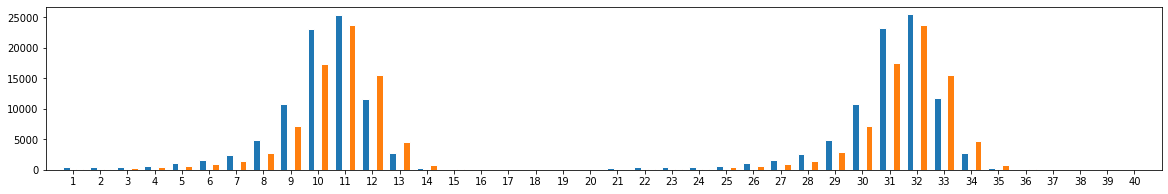

In [116]:
import matplotlib.pyplot as plt
x_range = bee_mean.shape[0]
x, y1, y2 = np.arange(x_range), bee_mean, flag_mean
fig, ax = plt.subplots()
ax.bar(x - 0.25, y1, width=0.25, edgecolor="white")
ax.bar(x + 0.25, y2, width=0.25, edgecolor="white")
ax.set(xlim=(0, max(x)),xticks=np.arange(1, max(x)))
plt.show()

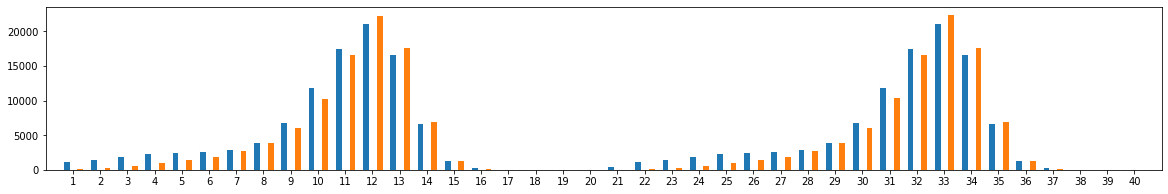

In [117]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

x_range = bee_mean.shape[0]
x, y1, y2 = np.arange(x_range), veg_mean, airshow_mean
fig, ax = plt.subplots()

ax.bar(x - 0.25, y1, width=0.25, edgecolor="white")
ax.bar(x + 0.25, y2, width=0.25, edgecolor="white")
ax.set(xlim=(0, max(x)),xticks=np.arange(1, max(x)))
plt.show()

In [44]:
cosine_similarity(bee_mean[None,:], flag_mean[None,:])

array([[0.9820208]], dtype=float32)

In [10]:
cosine_similarity(airshow_mean[None,:], veg_mean[None,:])

array([[0.99484986]], dtype=float32)

# Automatic Average Histogram

In [41]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pandas as pd
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [42]:
with open("classes", "rb") as f:   # Unpickling
    classes = pickle.load(f)

In [43]:
outputs = np.load("results_numscale20_downfac_root_2_no_norm_44100.npy")

In [44]:
VID_PER_CLASS = 98
C1 = 'bee'
C2 = 'flag'

In [45]:
c1_index = classes.index(C1)
c2_index = classes.index(C2)

In [46]:
c1_outputs = outputs[c1_index * VID_PER_CLASS: (c1_index + 1) * VID_PER_CLASS]
c2_outputs = outputs[c2_index * VID_PER_CLASS: (c2_index + 1) * VID_PER_CLASS]

In [47]:
c1_mean = np.mean(c1_outputs, axis=0)
c2_mean = np.mean(c2_outputs, axis=0)

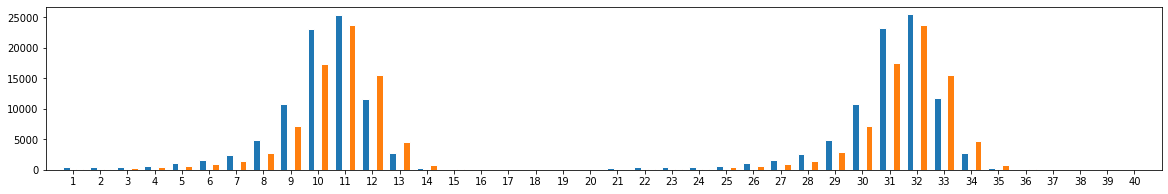

In [31]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

x_range = c1_mean.shape[0]
x, y1, y2 = np.arange(x_range), c1_mean, c2_mean
fig, ax = plt.subplots()
ax.bar(x - 0.25, y1, width=0.25, edgecolor="white")
ax.bar(x + 0.25, y2, width=0.25, edgecolor="white")
ax.set(xlim=(0, max(x)),xticks=np.arange(1, max(x)))
plt.show()

# Metric Learning

In [31]:
from metric_learn import NCA
import numpy as np
import pickle
import itertools
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [12]:
outputs = np.load("results.npy")

In [13]:
with open("classes", "rb") as f:   # Unpickling
    classes = pickle.load(f)

In [19]:
### build numeric labels for the data
NUM_CLASS = 19
NUM_PER_CLASS = outputs.shape[0] // NUM_CLASS
lables = [[i] * NUM_PER_CLASS for i in range(NUM_CLASS)]
lables = list(itertools.chain(*lables))

In [24]:
### split data into train and test sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(outputs, lables, test_size=0.2, random_state=42)

In [32]:
nca = NCA(verbose=True)
train_transformed = nca.fit_transform(X_train, y_train)
test_transformed = nca.transform(X_test)

[NCA]
[NCA]  Iteration      Objective Value    Time(s)
[NCA] ------------------------------------------
[NCA]          0         7.590000e+02       0.11
[NCA] Training took     0.12s.


In [54]:
K = 10
knn = KNeighborsClassifier(n_neighbors=K, metric='euclidean')
knn.fit(train_transformed, y_train)
pred = knn.predict(test_transformed)
(pred == y_test).sum()/len(pred)

0.45576407506702415

# multi-scaling and downsampling with non-integer factor

In [50]:
PATH = './videos/bee_101.mp3'

In [27]:
import os
PATH_AUDIO = "/home/eftekhar/Documents/Databases/AVDT_backup/Audios"
for d in os.listdir(PATH_AUDIO):
#     classes.append(d)
    audios = os.listdir(os.path.join(PATH_AUDIO, d))
#     m = min(100, len(audios))
    for aud in os.listdir(os.path.join(PATH_AUDIO, d))[:98]:
        print(d)
        audio_path = os.path.join(PATH_AUDIO, d, aud)
        # x,sr=a2n.audio_from_file(audio_path)
        x, s = librosa.load(audio_path)
        # x = ((x[:,0] + x[:,1])/2)[:,None]
        n = highestPowerof2(x.shape[0])
        x = x[x.shape[0] // 2 - n // 2 : x.shape[0] // 2 + n // 2]

flag


/home/eftekhar/anaconda3/envs/SOE_NET/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


flag


/home/eftekhar/anaconda3/envs/SOE_NET/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


flag


/home/eftekhar/anaconda3/envs/SOE_NET/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


flag


/home/eftekhar/anaconda3/envs/SOE_NET/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


flag


/home/eftekhar/anaconda3/envs/SOE_NET/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


flag


/home/eftekhar/anaconda3/envs/SOE_NET/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


flag


/home/eftekhar/anaconda3/envs/SOE_NET/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


flag


/home/eftekhar/anaconda3/envs/SOE_NET/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


flag


KeyboardInterrupt: 

In [51]:
import librosa   
import numpy as np
import tensorflow as tf
from SOE_NET_1D import conv1d
import configure as cfg
import init_SOE_NET as init_net
import math
from util import highestPowerof2

tf.compat.v1.enable_eager_execution()


y, s = librosa.load(PATH)

/home/eftekhar/anaconda3/envs/SOE_NET/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [5]:
y = librosa.resample(y, orig_sr=s, target_sr=2*s)
y.shape

(285768,)

In [6]:
x = y

In [8]:
n = highestPowerof2(x.shape[0])
x = x[x.shape[0] // 2 - n // 2 : x.shape[0] // 2 + n // 2]
vol = tf.constant(x[None,:,None], dtype=tf.float32)

In [9]:
vol.shape

TensorShape([Dimension(1), Dimension(262144), Dimension(1)])

In [9]:
y.shape

(142884,)

In [53]:
gau_filter = init_net.initSeparableFilters('basis', cfg.FILTER_TAPS, filter_type="G3")

In [63]:
n = 2**(21)
delta = [0] * n
delta[n//2] = 1
vol = tf.constant(delta, dtype=tf.float32)[None, :, None]

In [69]:
def SC1D_non_int_fac(name, in_data, basis, down_fac, num_scale):
    all_scales = []
    
    all_scales.append(conv1d('G_a_scale{}'.format(0), in_data, basis[0,:]))
    
    in_data_np = np.squeeze(in_data.numpy())
    n = in_data_np.shape[0]
    for i in range(1, num_scale + 1):
        resample_rate = cfg.ORIGINAL_SAMPLING_RATE // (down_fac ** i)
        x = librosa.resample(in_data_np, orig_sr = cfg.ORIGINAL_SAMPLING_RATE, target_sr = resample_rate)
        x = tf.constant(x[None,:,None], dtype=tf.float32)
        x = conv1d('G_a_scale{}'.format(i), x, basis[0,:])
        x = np.squeeze(x.numpy())       
        x = librosa.resample(x, orig_sr = resample_rate, target_sr = cfg.ORIGINAL_SAMPLING_RATE) 
        x = tf.constant(x[None,:,None], dtype=tf.float32)
#         x = x / cfg.MULTI_SCALING_NORM_FACTORS[i]
#         x = x[:, x.shape[1] // 2 - n // 2 : x.shape[1] // 2 + n // 2, :]
        all_scales.append(x)
        
#     max_len = max([x.get_shape().as_list()[1] for x in all_scales])
#     for 
    
    
        print(x.shape)
        print(i)
#     return tf.concat(axis=-1, values=all_scales, name='concatScales')
    return all_scales

In [24]:
vol = tf.constant(y[None,:,None], dtype=tf.float32)

In [32]:
2**17

131072

In [70]:
conv1 = SC1D_non_int_fac('conv1', vol, gau_filter, math.sqrt(2), 25)

(1, 2097153, 1)
1
(1, 2097153, 1)
2
(1, 2097155, 1)
3
(1, 2097155, 1)
4
(1, 2097155, 1)
5
(1, 2097159, 1)
6
(1, 2097162, 1)
7
(1, 2097167, 1)
8
(1, 2097173, 1)
9
(1, 2097183, 1)
10
(1, 2097195, 1)
11
(1, 2097186, 1)
12
(1, 2097200, 1)
13
(1, 2097186, 1)
14
(1, 2097302, 1)
15
(1, 2097314, 1)
16
(1, 2097323, 1)
17
(1, 2097314, 1)
18
(1, 2097690, 1)
19
(1, 2097900, 1)
20
(1, 2097690, 1)
21
(1, 2099160, 1)
22
(1, 2097900, 1)
23
(1, 2099160, 1)
24
(1, 2102100, 1)
25


# Confusion matrix


In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pandas as pd
from scipy import stats
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [8]:
with open("20classes", "rb") as f:   # Unpickling
    classes = pickle.load(f)

In [9]:
outputs = np.load("results_2layer_numscale20_downfac_root_2_no_norm1_librosa_44100_one_path_kaiser_fast_20_classes.npy")

In [10]:
sim_pairs = cosine_similarity(outputs)

In [11]:
sorted_sim = np.argsort(sim_pairs, axis=1)

In [12]:
NN = sorted_sim[:,-2].tolist()
c = 0
for i, s in enumerate(NN):
    if s // 98 == i // 98:
        c = c + 1
c / len(NN)        

0.5821428571428572

In [13]:
labels = [n // 98 for n in NN]

In [14]:
ground_truth = [i // 98 for i in range(len(labels))]

In [15]:
conf_mat = confusion_matrix(ground_truth, labels, normalize='true')

<AxesSubplot:>

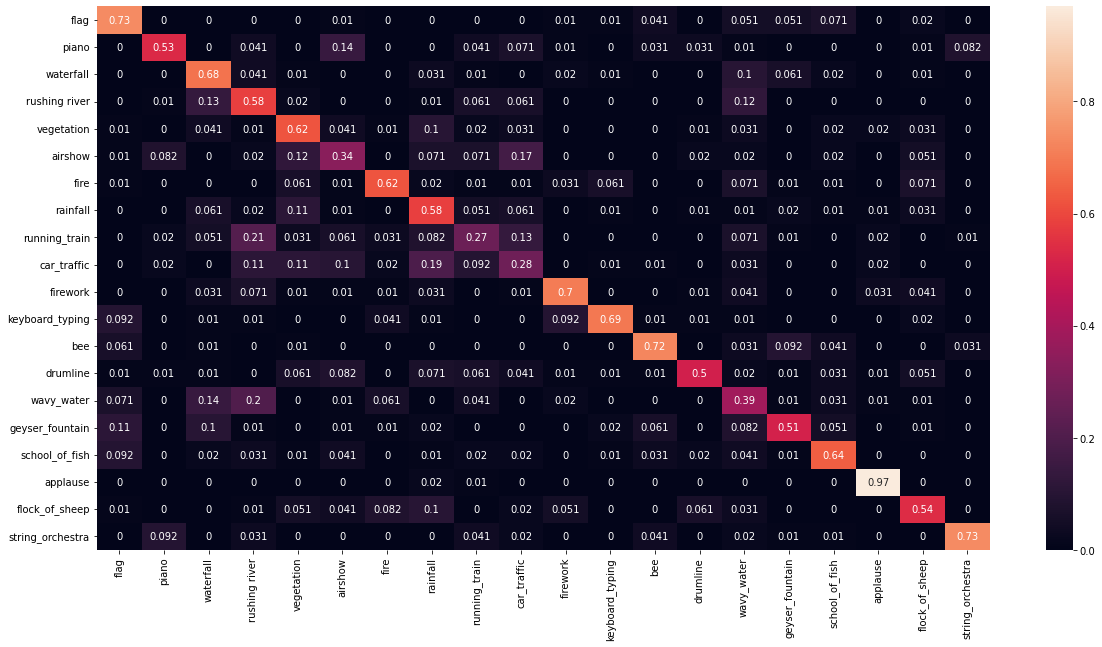

In [16]:
df_cm = pd.DataFrame(conf_mat, index = classes, columns = classes)
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

In [40]:
conf_mat = confusion_matrix(ground_truth, labels, normalize='pred')

<AxesSubplot:>

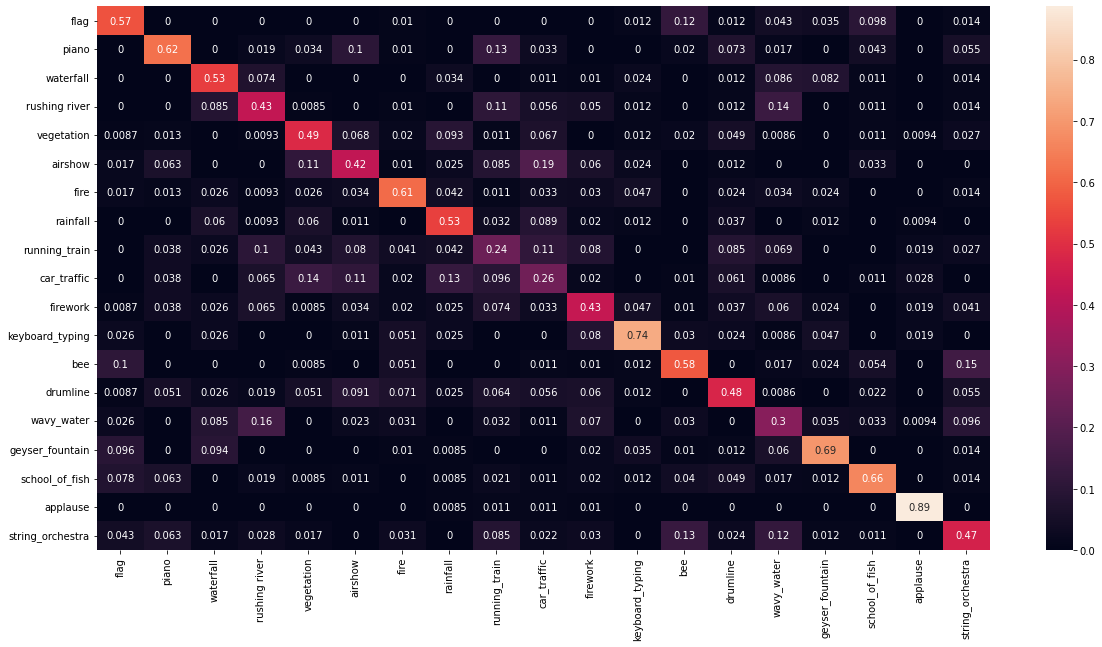

In [41]:
df_cm = pd.DataFrame(conf_mat, index = classes, columns = classes)
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

# similar pairs between classes

In [15]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pandas as pd
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
import os

In [16]:
with open("classes", "rb") as f:   # Unpickling
    classes = pickle.load(f)

In [69]:
outputs = np.load("results_numscale20_downfac_root_2_no_norm_librosa_44100.npy")

In [73]:
VID_PER_CLASS = 98
C1 = 'car_traffic'
C2 = 'rushing river'

In [74]:
c1_index = classes.index(C1)
c2_index = classes.index(C2)

In [75]:
c1_outputs = outputs[c1_index * VID_PER_CLASS: (c1_index + 1) * VID_PER_CLASS]
c2_outputs = outputs[c2_index * VID_PER_CLASS: (c2_index + 1) * VID_PER_CLASS]

In [76]:
sim_pairs = cosine_similarity(c1_outputs, c2_outputs)

In [77]:
x, y = np.where(sim_pairs == np.amax(sim_pairs))

In [78]:
x, y = x.item(), y.item()

In [83]:
PATH_AUDIO = "/home/eftekhar/Documents/Databases/AVDT_backup/Audios"

d1 = os.path.join(PATH_AUDIO, C1)
d2 = os.path.join(PATH_AUDIO, C2)

print(os.listdir(d1)[x])
print(os.listdir(d2)[y])

carTraffic (91).mp3
vegetation_192.mp3


In [26]:
np.amax(sim_pairs)

0.99908173

In [29]:
c1_outputs[x,:]

array([5.0222803e+02, 8.0545526e+02, 6.7644128e+02, 7.8915576e+02,
       8.7804480e+02, 1.0810317e+03, 1.0933525e+03, 7.7701550e+02,
       8.6268250e+02, 2.3914644e+03, 7.1125869e+03, 1.7462953e+04,
       2.9125637e+04, 2.6482076e+04, 1.1896379e+04, 2.1877258e+03,
       1.3525087e+02, 1.0946440e+01, 2.9483135e+00, 1.5026824e+00,
       1.1841532e+00, 5.0220438e+02, 8.0468396e+02, 6.7434033e+02,
       7.8592358e+02, 8.7990308e+02, 1.0805149e+03, 1.1007856e+03,
       7.9167352e+02, 8.8707300e+02, 2.5101299e+03, 7.4077070e+03,
       1.8007570e+04, 2.9579391e+04, 2.6650094e+04, 1.2316391e+04,
       2.3004504e+03, 1.3621967e+02, 1.1083696e+01, 2.6403468e+00,
       1.2390233e+00, 1.0565817e+00], dtype=float32)

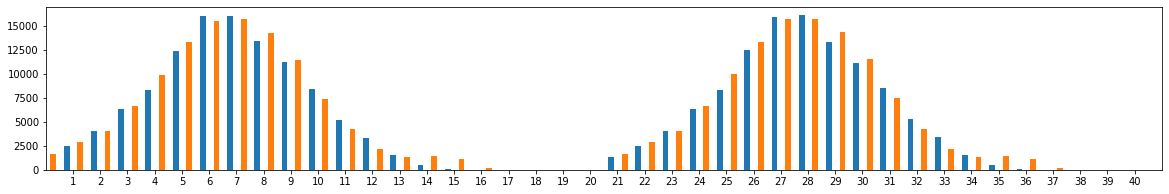

In [79]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
x_range = c1_outputs[x,:].shape[0]
y1, y2 =  c1_outputs[x,:], c2_outputs[y,:]
x = np.arange(x_range)
fig, ax = plt.subplots()
ax.bar(x - 0.25, y1, width=0.25, edgecolor="white")
ax.bar(x + 0.25, y2, width=0.25, edgecolor="white")
ax.set(xlim=(0, max(x)),xticks=np.arange(1, max(x)))
plt.show()

# Modifiying conv layer

In [1]:
def SC1D_non_int_fac(name, in_data, basis, down_fac, num_scale):
    all_scales = []
    
    all_scales.append(conv1d('G_a_scale{}'.format(0), in_data, basis[0,:]))
    
    in_data_np = np.squeeze(in_data.numpy())
    n = in_data_np.shape[0]
    for i in range(1, num_scale + 1):
        resample_rate = cfg.ORIGINAL_SAMPLING_RATE // (down_fac ** i)
        x = librosa.resample(in_data_np, orig_sr = cfg.ORIGINAL_SAMPLING_RATE, target_sr = resample_rate)
        x = tf.constant(x[None,:,None], dtype=tf.float32)
        x = conv1d('G_a_scale{}'.format(i), x, basis[0,:])
        x = np.squeeze(x.numpy())       
        x = librosa.resample(x, orig_sr = resample_rate, target_sr = cfg.ORIGINAL_SAMPLING_RATE) 
        x = tf.constant(x[None,:,None], dtype=tf.float32)
        # x = x / cfg.MULTI_SCALING_NORM_FACTORS[i]
        x = x[:, x.shape[1] // 2 - n // 2 : x.shape[1] // 2 + n // 2, :]
        all_scales.append(x)
        
    return tf.concat(axis=-1, values=all_scales, name='concatScales')



In [2]:
import configure as cfg
import tensorflow as tf
import numpy as np
import init_SOE_NET as init_net
from SOE_NET_1D import conv1d
import librosa

def SC1D(name, in_data, basis, down_fac, num_scale):
    all_scales = []
    
    all_scales.append(conv1d('G_a_scale{}'.format(0), in_data, basis[0,:]))
    
    in_data_np = in_data.numpy()
    n = in_data_np.shape[1]
    for i in range(1, num_scale + 1):
        resample_rate = cfg.ORIGINAL_SAMPLING_RATE // (down_fac ** i)
        x = down_sampling_multi_channels(in_data_np, resample_rate)
#         x = librosa.resample(in_data_np, orig_sr = cfg.ORIGINAL_SAMPLING_RATE, target_sr = resample_rate)
        x = tf.constant(x, dtype=tf.float32)
        x = conv1d('G_a_scale{}'.format(i), x, basis[0,:])
        x = x.numpy()       
#         x = librosa.resample(x, orig_sr = resample_rate, target_sr = cfg.ORIGINAL_SAMPLING_RATE) 
        x = up_sampling_multi_channels(x, resample_rate)
        x = tf.constant(x, dtype=tf.float32)
        # x = x / cfg.MULTI_SCALING_NORM_FACTORS[i]
        x = x[:, x.shape[1] // 2 - n // 2 : x.shape[1] // 2 + n // 2, :]
        all_scales.append(x)
        
    return tf.concat(axis=-1, values=all_scales, name='concatScales')



In [3]:
def down_sampling_multi_channels(x, resample_rate):
    num_channels = x.shape[2]
    output = []
    for ch in range(num_channels):
        output.append(librosa.resample(x[0, :, ch], orig_sr = cfg.ORIGINAL_SAMPLING_RATE, target_sr = resample_rate)[None, :, None])
    return np.concatenate(output, axis=2)

In [4]:
def up_sampling_multi_channels(x, resample_rate):
    num_channels = x.shape[2]
    output = []
    for ch in range(num_channels):
        output.append(librosa.resample(x[0, :, ch], orig_sr = resample_rate, target_sr = cfg.ORIGINAL_SAMPLING_RATE)[None, :, None])
    return np.concatenate(output, axis=2)

In [37]:
import math
x = np.random.rand(1, 262144, 20)
resample_rate = cfg.ORIGINAL_SAMPLING_RATE // (math.sqrt(2) ** 1)
d = down_sampling_multi_channels(x, resample_rate)
up_sampling_multi_channels(d, resample_rate).shape

(1, 262145, 20)

In [33]:
262144 / 185362

1.4142272957779911

In [14]:


import time
start_time = time.time()

# tf.compat.v1.enable_eager_execution()

vol1 = np.random.rand(1, 262144, 1)
vol1 = tf.constant(vol1, dtype=tf.float32)

gau_filter = init_net.initSeparableFilters('basis', cfg.FILTER_TAPS, filter_type="G3")


conv1 = SC1D('conv1', vol1, gau_filter, cfg.DOWN_SAMPLE_FACTOR, cfg.NUM_SCALES)
conv2 = SC1D_non_int_fac('conv1', vol1, gau_filter, cfg.DOWN_SAMPLE_FACTOR, cfg.NUM_SCALES)
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.1563878059387207 seconds ---


In [15]:
tf.math.reduce_all(tf.math.equal(conv1,conv2))

<tf.Tensor: id=2515, shape=(), dtype=bool, numpy=True>

In [3]:
from SOE_NET_1D import SOE_Net
import configure as cfg
import init_SOE_NET as init_net
import numpy as np
import tensorflow as tf
from SOE_NET_1D import conv1d
from util import highestPowerof2
import audio2numpy as a2n
import librosa
import matplotlib.pyplot as plt       
# from SOE_NET_1D import SC1D, TPR, FWR, DivNorm1d, GSP
import os
from util import bar_plot
import pickle

import time
start_time = time.time()

tf.compat.v1.enable_eager_execution()
gau_filter = init_net.initSeparableFilters('basis', cfg.FILTER_TAPS, filter_type="G3")

PATH_AUDIO = "/home/eftekhar/Documents/Databases/AVDT_backup/Audios"

classes = []
outputs = []
for d in os.listdir(PATH_AUDIO):
    classes.append(d)
    audios = os.listdir(os.path.join(PATH_AUDIO, d))
#     m = min(100, len(audios))
    for aud in os.listdir(os.path.join(PATH_AUDIO, d))[:98]:
        print(d)
        audio_path = os.path.join(PATH_AUDIO, d, aud)
        # x,sr=a2n.audio_from_file(audio_path)
        x, s = librosa.load(audio_path, sr=cfg.ORIGINAL_SAMPLING_RATE)
        x = x / np.amax(np.abs(x))
        # x = ((x[:,0] + x[:,1])/2)
        n = highestPowerof2(x.shape[0])
        x = x[x.shape[0] // 2 - n // 2 : x.shape[0] // 2 + n // 2]
        vol = tf.constant(x[None,:,None], dtype=tf.float32)
        print(vol.shape)
        output = SOE_Net(vol, gau_filter)
        outputs.append(output.numpy())
        break
    break
print("--- %s seconds ---" % (time.time() - start_time))
# np.save("results_numscale20_downfac_root_2_no_norm_librosa_44100_apm.npy", np.concatenate(outputs, axis=0))

# with open("classes_for_results_numscale10_downfac_2_no_norm_old", "wb") as f:   #Pickling
#     pickle.dump(classes, f)


flag


/home/eftekhar/anaconda3/envs/SOE_NET/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(1, 262144, 1)
--- 23.695122480392456 seconds ---


In [3]:
output

<tf.Tensor: id=1919, shape=(1, 84), dtype=float32, numpy=
array([[1.3816388e+02, 6.1273077e+02, 2.0388280e+03, 4.6148975e+03,
        8.3173730e+03, 8.8833262e+03, 5.2183145e+03, 2.6735309e+02,
        1.8676340e+02, 3.4060382e+02, 1.6393391e+03, 2.8753972e+03,
        1.0293870e+03, 6.8859390e+01, 1.3071711e+01, 4.7669318e-01,
        1.7829424e-03, 1.0042757e-04, 5.4072210e-05, 2.6403872e-05,
        1.2820914e-05, 1.3710889e+02, 6.0438892e+02, 2.0097678e+03,
        4.5717959e+03, 8.2561904e+03, 8.8263223e+03, 5.2100952e+03,
        2.6491028e+02, 1.6557381e+02, 3.3053159e+02, 1.6470750e+03,
        2.8274487e+03, 1.0375059e+03, 7.0095337e+01, 1.3975152e+01,
        5.0520623e-01, 6.6116464e-04, 3.1159143e-06, 4.1986601e-07,
        2.3786167e-07, 1.9334524e-07, 1.4457812e+02, 6.5830194e+02,
        2.0400734e+03, 5.1907588e+03, 7.6289443e+03, 1.0731959e+04,
        4.0803203e+03, 2.7877902e+02, 1.8135956e+02, 3.3809039e+02,
        1.5894927e+03, 2.8721855e+03, 1.0014702e+03, 6.833

In [1]:
from SOE_NET_1D import SOE_Net
import configure as cfg
import init_SOE_NET as init_net
import numpy as np
import tensorflow as tf
from SOE_NET_1D import conv1d
from util import highestPowerof2
import audio2numpy as a2n
import librosa
import matplotlib.pyplot as plt       
from SOE_NET_1D import SC1D, TPR, FWR, DivNorm1d, GSP, SC1D_MULTI_CH
import os
from util import bar_plot
import pickle

tf.compat.v1.enable_eager_execution()
gau_filter = init_net.initSeparableFilters('basis', cfg.FILTER_TAPS, filter_type="G3")


2022-07-28 22:20:40.428069: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-07-28 22:20:40.431920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Quadro P6000 major: 6 minor: 1 memoryClockRate(GHz): 1.645
pciBusID: 0000:65:00.0
2022-07-28 22:20:40.432082: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-07-28 22:20:40.433062: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-07-28 22:20:40.433906: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-07-28 22:20:40.434127: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-07-28 22:20:40.435183: I tensorflow/stream_executor/platform/defa

In [3]:
vol = np.random.rand(1, 262144, 21)
vol = tf.constant(vol, dtype=tf.float32)

import time
start_time = time.time()

vol = SC1D_MULTI_CH('conv1', vol, gau_filter, cfg.DOWN_SAMPLE_FACTOR, cfg.NUM_SCALES)
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.416281461715698 seconds ---


In [4]:
vol.shape

TensorShape([Dimension(1), Dimension(262144), Dimension(441)])

In [6]:
2**18

262144

# channel wise pooling 

In [13]:
def CP3D(name, in_data, num_scales, rectification_type):
    num_ch = in_data.get_shape().as_list()[-1]
    output = []
    if rectification_type == 'one_path':
        for s in range(num_scales+1):
            sliced = in_data[:,:,s:num_ch:num_scales+1]
            output.append(tf.reduce_mean(sliced, axis=-1, keep_dims=True))
            
        return tf.concat(output, axis = -1)
    else:
        pass
    

In [14]:
CP3D("hi", vol, 20, "one_path")

<tf.Tensor: id=279, shape=(1, 262144, 21), dtype=float32, numpy=
array([[[0.47640958, 0.587796  , 0.48244253, ..., 0.5027801 ,
         0.47877374, 0.5269707 ],
        [0.581561  , 0.49780536, 0.5677166 , ..., 0.39149174,
         0.42115653, 0.39053136],
        [0.6004311 , 0.43176433, 0.52855355, ..., 0.511485  ,
         0.48869506, 0.52652085],
        ...,
        [0.5301098 , 0.5484703 , 0.47165748, ..., 0.5889327 ,
         0.5235284 , 0.5254437 ],
        [0.5616927 , 0.5201645 , 0.48361364, ..., 0.5569017 ,
         0.53914374, 0.46417236],
        [0.43116832, 0.5454833 , 0.5499594 , ..., 0.4211827 ,
         0.5639369 , 0.4808824 ]]], dtype=float32)>

In [2]:
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

vol = np.random.rand(1, 262144, 21**2)
vol = tf.constant(vol, dtype=tf.float32)


In [6]:
tf.reduce_mean(vol[:,:, 0:21:4], axis=-1, keep_dims=True)

<tf.Tensor: id=25, shape=(1, 262144, 1), dtype=float32, numpy=
array([[[0.36580768],
        [0.43485153],
        [0.49920794],
        ...,
        [0.5259928 ],
        [0.62347347],
        [0.29317093]]], dtype=float32)>

In [12]:
vol[0,:, 0:21:4]

<tf.Tensor: id=17, shape=(262144, 6), dtype=float32, numpy=
array([[0.3417115 , 0.8988732 , 0.8083679 , 0.67268854, 0.66478705,
        0.6446315 ],
       [0.48696908, 0.75066346, 0.35884008, 0.45907232, 0.17568973,
        0.36224395],
       [0.5443283 , 0.9681517 , 0.41807553, 0.71268153, 0.6669936 ,
        0.7651957 ],
       ...,
       [0.6923137 , 0.8851998 , 0.00359805, 0.14819947, 0.5683861 ,
        0.90413314],
       [0.20858252, 0.86180985, 0.00103352, 0.19782951, 0.2651087 ,
        0.25977874],
       [0.56785935, 0.15481   , 0.6188424 , 0.9928004 , 0.9061434 ,
        0.04529678]], dtype=float32)>

In [6]:
a = np.random.rand(1, 262144, 21**2)

In [10]:
a[0,:, 19:21].shape

(262144, 2)

# channel wise pooling

In [1]:
import tensorflow as tf
import numpy as np
from SOE_Net_model_full import *
import init_SOE_NET as init_net
import configure as cfg

In [2]:
tf.compat.v1.enable_eager_execution()

In [3]:
vol = np.random.rand(1, 42, 4 * 21**2)
vol = tf.constant(vol, dtype=tf.float32)

2022-09-28 21:01:54.512365: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-28 21:01:54.536311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Quadro P6000 major: 6 minor: 1 memoryClockRate(GHz): 1.645
pciBusID: 0000:65:00.0
2022-09-28 21:01:54.536559: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-09-28 21:01:54.538627: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-09-28 21:01:54.540385: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-09-28 21:01:54.540830: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-09-28 21:01:54.543344: I tensorflow/stream_executor/platform/defa

In [4]:
NUM_SCALE = 21

In [5]:
num_ch = vol.get_shape().as_list()[-1]
num_block = num_ch // (NUM_SCALE ** 2)
pooled = []
for i in range(num_block):
    vol_slice = vol[:,:,i*(NUM_SCALE ** 2): (i + 1)*(NUM_SCALE ** 2)]
    for j in range(NUM_SCALE):
        pooled.append(tf.reduce_mean(vol_slice[:,:,j::NUM_SCALE], axis=-1, keepdims=True))
output = tf.concat(pooled, axis=-1)

In [6]:
num_ch = vol.get_shape().as_list()[-1]
l = []
for i in range(NUM_SCALE):
    x = np.zeros((NUM_SCALE ** 2, 1), dtype=np.float32)
    x[i::NUM_SCALE] = 1.0 / NUM_SCALE
    l.append(x)
chunk = np.concatenate(l, axis=-1)
f = np.zeros((num_ch, num_ch // NUM_SCALE), dtype=np.float32)
for i in range(num_ch // (NUM_SCALE ** 2)):
    f[i * (NUM_SCALE ** 2): (i + 1) * (NUM_SCALE ** 2), i * NUM_SCALE: (i + 1) * NUM_SCALE] = chunk

output1 = tf.nn.conv1d(vol, tf.constant(f[None,:,:], dtype=tf.float32), stride=[1, 1, 1], padding='VALID')


2022-09-28 21:01:55.173665: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


In [7]:
tf.math.reduce_max(output - output1)

<tf.Tensor: id=532, shape=(), dtype=float32, numpy=1.1920929e-07>

In [10]:
output1.get_shape().as_list()

[1, 42, 84]